# Boosting
##### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

from data import get_data

### Data Loading + Preprocessing

In [2]:
ROOT = './tadpole_challenge/'
X, y, label_dict = get_data(ROOT, isCorr = True)
print(label_dict)

{0: 'AD', 1: 'CN', 2: 'MCI'}


##### Split data into Train and Test datasets

In [3]:
# create training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

### Helper Functions

In [5]:
# Source: https://stackoverflow.com/questions/55632010/using-scikit-learns-mlpclassifier-in-adaboostclassifier
class CustomMLPClassifier(MLPClassifier):
    def resample_with_replacement(self, X_train, y_train, sample_weight):

        # normalize sample_weights if not already
        sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

        X_train_resampled = np.zeros((len(X_train), len(X_train[0])), dtype=np.float32)
        y_train_resampled = np.zeros((len(y_train)), dtype=np.int)
        for i in range(len(X_train)):
            # draw a number from 0 to len(X_train)-1
            draw = np.random.choice(np.arange(len(X_train)), p=sample_weight)

            # place the X and y at the drawn number into the resampled X and y
            X_train_resampled[i] = X_train[draw]
            y_train_resampled[i] = y_train[draw]

        return X_train_resampled, y_train_resampled


    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            X, y = self.resample_with_replacement(X, y, sample_weight)
        return self._fit(X, y, incremental=(self.warm_start and
                                            hasattr(self, "classes_")))

In [4]:
def boosting_clf(clf):
    if (isinstance(clf,SVC)):
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, algorithm = 'SAMME', learning_rate = 0.1)
    else:
        return AdaBoostClassifier(base_estimator = clf, n_estimators = 100, random_state = 0, learning_rate = 0.1)

In [5]:
def accuracy(clf, X, y):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    print('Balanced accuracy score: ', BCA)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovo", average="macro")
    print('Overall mAUC: ', mAUC)

In [6]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 'Actual ' + label_dict[2]))

    for i in range(3):
       for j in range(3):
           ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [7]:
def report_accuracy(clf):
    print('Train metrics:')
    accuracy(clf, X_train, y_train)
    print('\n\nTest metrics:')
    accuracy(clf, X_test, y_test)
    showConfusionMatrix(clf, X_test, y_test)

In [8]:
def evaluate(Classifier, **kwargs):
    print('+ Base learner')
    clf = Classifier(**kwargs).fit(X_train, y_train)
    report_accuracy(clf)
    print('+ Ensemble')
    boost_clf = boosting_clf(Classifier(**kwargs)).fit(X_train, y_train)
    report_accuracy(boost_clf)

In [11]:
def main():
    baselearners = [DecisionTreeClassifier, 
                    SVC, 
                    CustomMLPClassifier,
                    LogisticRegression]
    
    for learner in baselearners:
        print(learner)
        evaluate(learner)
        print()

### Model Training

##### Decision Tree

+ Base learner
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.7421635258984657
Overall mAUC:  0.8066226444238492


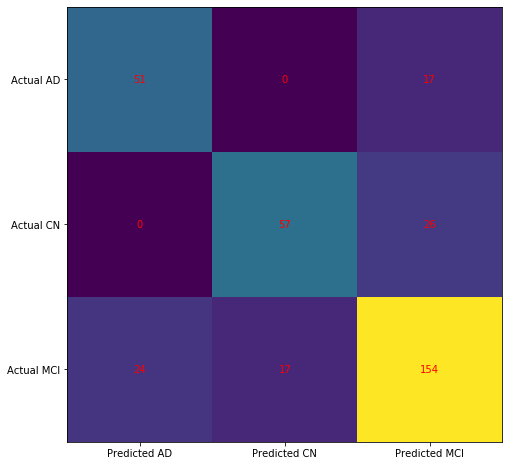

+ Ensemble
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.7553238595407269
Overall mAUC:  0.8164928946555451


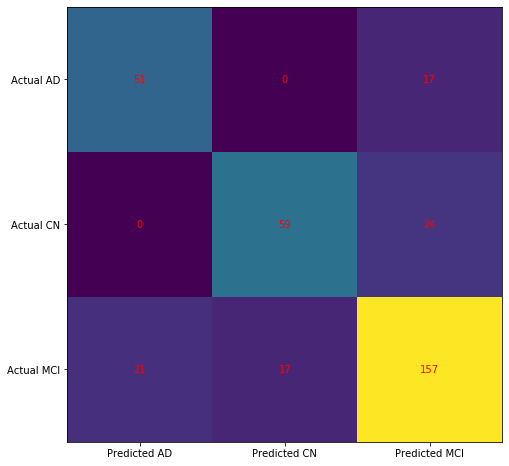

In [9]:
evaluate(DecisionTreeClassifier)

##### Logistic Regression Analysis (LRA)

+ Base learner
Train metrics:
Balanced accuracy score:  0.7458800511245586
Overall mAUC:  0.9431397535844738


Test metrics:
Balanced accuracy score:  0.7758166905934446
Overall mAUC:  0.9532281463713073


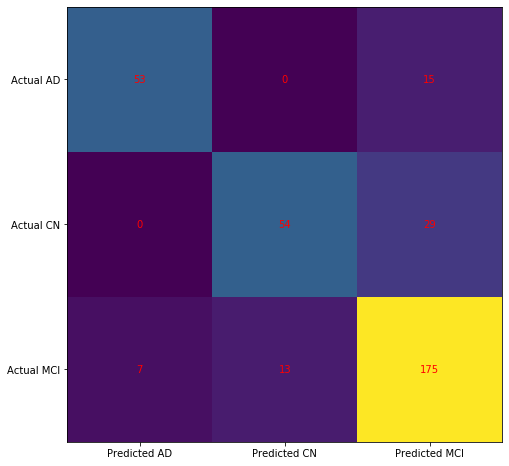

+ Ensemble
Train metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.8186044138848002


Test metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.8331629686165476


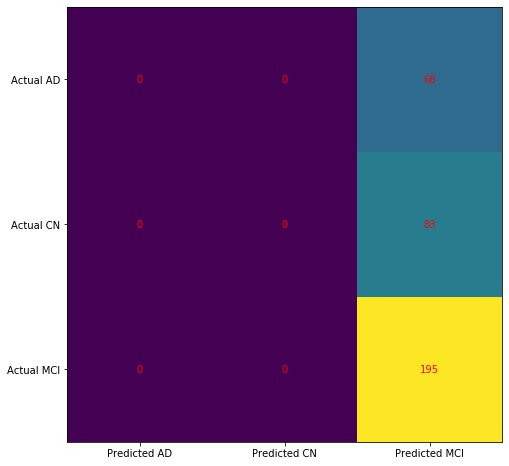

In [10]:
evaluate(LogisticRegression)

##### Artifical Neural Network (ANN)

+ Base learner
Train metrics:
Balanced accuracy score:  0.8532175355125703
Overall mAUC:  0.9608395552342844


Test metrics:
Balanced accuracy score:  0.8705017921146952
Overall mAUC:  0.9568903609831029


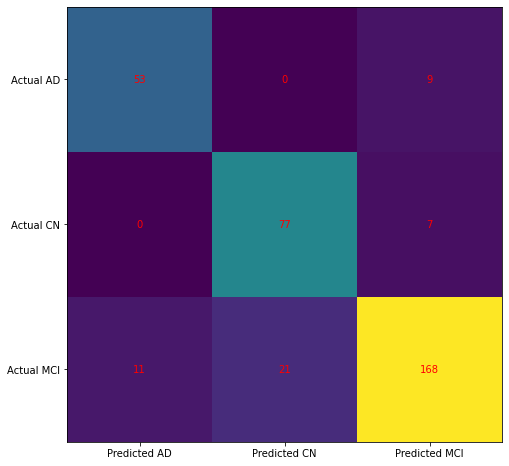

+ Ensemble
Train metrics:
Balanced accuracy score:  0.8231614525161861
Overall mAUC:  0.9390898180977683


Test metrics:
Balanced accuracy score:  0.8040092165898618
Overall mAUC:  0.9234520609318997


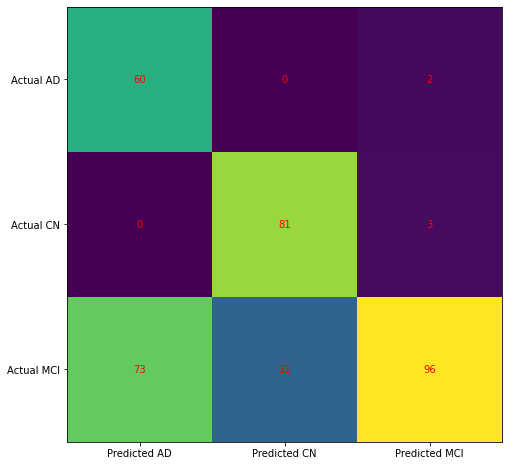

In [14]:
evaluate(CustomMLPClassifier)

##### SVM

+ Base learner
Train metrics:
Balanced accuracy score:  0.8315414751010074
Overall mAUC:  0.9585110805211796


Test metrics:
Balanced accuracy score:  0.8386105508004871
Overall mAUC:  0.9614162532482874


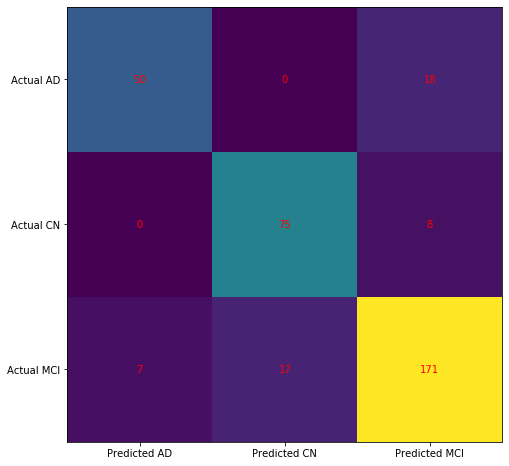

+ Ensemble
Train metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.5


Test metrics:
Balanced accuracy score:  0.3333333333333333
Overall mAUC:  0.5


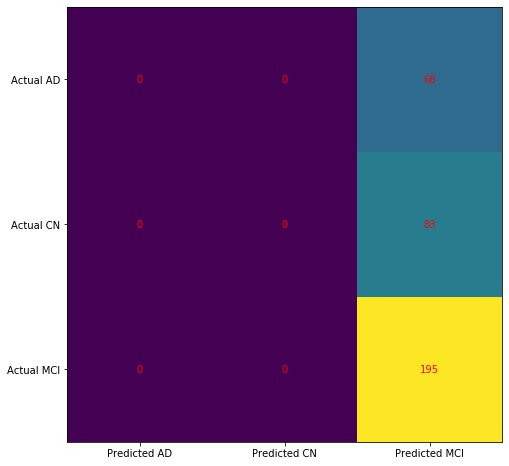

In [11]:
evaluate(SVC, probability = True)

##### All base learners at once

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
+ Base learner
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.8038965693804402
Overall mAUC:  0.8529224270353302


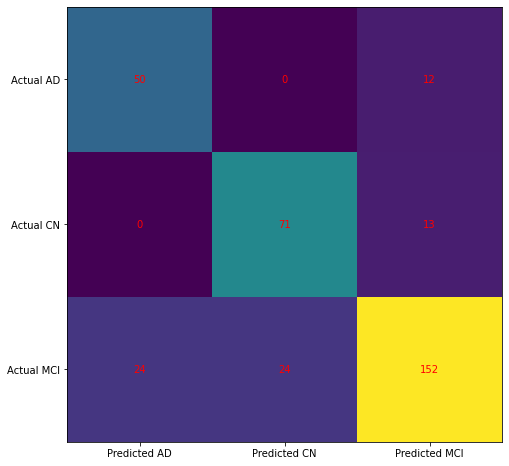

+ Ensemble
Train metrics:
Balanced accuracy score:  1.0
Overall mAUC:  1.0


Test metrics:
Balanced accuracy score:  0.7990348182283666
Overall mAUC:  0.8492761136712751


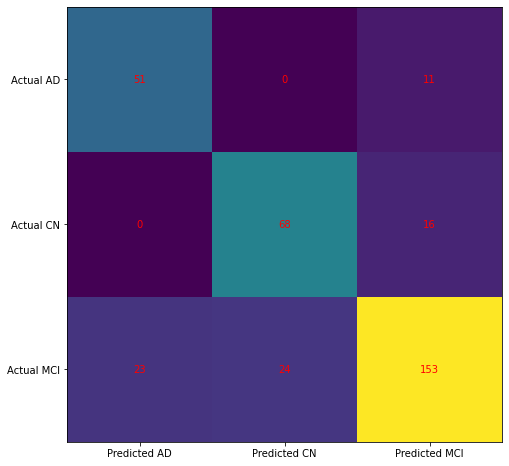


<class 'sklearn.svm._classes.SVC'>
+ Base learner
Train metrics:


AttributeError: predict_proba is not available when  probability=False

In [16]:
main()

### Experiment
Repeat 100 times